<a href="https://colab.research.google.com/github/GalinaChugreeva/CDs-VAE/blob/main/CDs%20VAE%20Chugreeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import re
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
import random
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from itertools import chain
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm import trange
import shutil

# I. Обучение сети на реальных данных

## 1.1. Датасет

In [2]:
class CDs_2D_dataset(Dataset):
    def __init__(self, annotations_file, spec_dir):
      '''annotations_file - the file which contains lables of the samples included in training/validation/test sets'''
      self.spec_labels = pd.read_csv(annotations_file, sep=',', decimal=",").iloc[:,1:] # labels (concentrations for 4 ions) for all the samples from annotation file (Y_ions.csv)
      self.spec_number = pd.read_csv(annotations_file, sep=',', decimal=",").iloc[:,0] # numbers for all the samples from annotation file (Y_ions.csv)
      self.spec_dir = spec_dir # folder where csv files are located


    def __len__(self):
        return len(self.spec_labels)#length of the dataset

    def __getitem__(self, idx):
        label = self.spec_labels.iloc[idx] # get the label of the sample via sample's index

        sp = np.array(pd.read_csv(self.spec_dir + str(self.spec_number[idx])+'_CorrectionData'+'.csv', skiprows=38, sep=';', decimal=",").iloc[6:-8,125:325].T, dtype='float32')/4544.595 # get the EEM of the sample via sample's index

        sp[sp<0]=0 # here we zero negative values of intensities
        spec = torch.from_numpy(sp).unsqueeze(0) # add dimension for channels of cnn


        return spec, torch.from_numpy(np.array(label, dtype='float32')) # return spectrum and corresponding labels


## 1.2. Архитектура нейросети

In [3]:
#2D CNN class (basic)
class twoD_CNN(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 94 * 7, 160)
        self.fc2 = nn.Linear(160, 5)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 1.3. Обновление весов

In [4]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

## 1.4. Запись ответов

In [5]:
def write_predictions(N, model_name, split_path,dataloader, dset):

    checkpoint = torch.load(split_path + 'model'+model_name+'.pth')
    N.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    last_best_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    N.eval()

    y_ae = np.zeros((1,5))
    y_ae_true = np.zeros((1,5))

    for specs, labels in dataloader:
        outputs = N(specs)
        outputs[outputs<0]=0
        ae = outputs.detach().numpy()
        ae_true = labels.detach().numpy()
        y_ae = np.concatenate((y_ae, ae), axis=0)
        y_ae_true = np.concatenate((y_ae_true, ae_true), axis=0)

    a = ['Cu','Ni','Cr','NO3', 'pH']

    pd.DataFrame(y_ae).to_csv(split_path + 'Y_out_'+'_'+dset+'.csv',sep=',', header = a)
    pd.DataFrame(y_ae_true).to_csv(split_path + 'Y_true_'+'_'+dset+'.csv',sep=',', header = a)

## 1.5. Кросс-валидация

In [6]:
!wget -qN https://github.com/GalinaChugreeva/CDs-VAE/raw/main/CD_HM_dataset.zip
!unzip -qn CD_HM_dataset.zip

In [8]:
gen_path = ''

case_name = '2D_CNN'
cnn_2d_path = case_name+'/'

Y = pd.read_csv(gen_path+'CD_HM_dataset/'+'Y_ions'+'.csv', sep=',')


k_folds = [[42,12],[612,45],[72,172]]

fold = k_folds[0]
Y_trn, Y_30 = train_test_split(Y, test_size=0.3, random_state=fold[0])
Y_vld, Y_tst = train_test_split(Y_30, test_size = 0.3333, random_state=fold[1])

for fold in k_folds:
    split_path = gen_path+cnn_2d_path+'split_'+ str(fold[0])+'_'+str(fold[1])+ '/'
    os.makedirs(split_path, exist_ok=True)

    Y_trn, Y_30 = train_test_split(Y, test_size=0.3, random_state=fold[0])
    Y_vld, Y_tst1 = train_test_split(Y_30, test_size = 0.3333, random_state=fold[1])

    a = ['sample_number','Cu','Ni','Cr','NO3', 'pH']

    pd.DataFrame(Y_trn).to_csv(split_path + 'Y_trn'+'.csv',sep=',', index=False, header = a)
    pd.DataFrame(Y_vld).to_csv(split_path + 'Y_vld'+'.csv',sep=',', index=False, header = a)
    pd.DataFrame(Y_tst).to_csv(split_path + 'Y_tst'+'.csv',sep=',', index=False, header = a)

## 1.6. Обучение

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = twoD_CNN()

loss_function = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.002)
case_name = '2D_CNN'

for fold in k_folds:

    cnn_2d_path = case_name+'/'
    split_path = gen_path+cnn_2d_path+'split_'+ str(fold[0])+'_'+str(fold[1])+ '/'


    training_data = CDs_2D_dataset(split_path+'Y_trn'+'.csv', gen_path + 'CD_HM_dataset/')
    validation_data = CDs_2D_dataset(split_path+'Y_vld'+'.csv', gen_path + 'CD_HM_dataset/')
    test_data = CDs_2D_dataset(split_path+'Y_tst'+'.csv', gen_path + 'CD_HM_dataset/')

    train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
    validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


    for init_number in range(0,2):

      init_path = split_path + str(init_number)+'/'
      os.makedirs(init_path, exist_ok=True)

      test_stop = 100
      max_val_loss = 10000.0

      split_name = 'split_'+ str(fold[0])+'_'+str(fold[1])
      init_name = '_' + str(init_number)
      model_name = '_2D_CNN'


      for epoch_step in range(0, 5000, test_stop):

          if epoch_step!=0:
              checkpoint = torch.load(init_path + 'model'+model_name+'.pth')
              model.load_state_dict(checkpoint['model_state_dict'])
              optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
              last_best_epoch = checkpoint['epoch']
              loss = checkpoint['loss']
              model.train()

              if last_best_epoch + test_stop > ep:
                  for ep in range(epoch_step, epoch_step+test_stop):
                      for _, data in enumerate(train_dataloader, 0):
                          inputs, labels = data
                          optimizer.zero_grad()
                          outputs = model(inputs)
                          loss = loss_function(outputs, labels)
                          loss.backward()
                          optimizer.step()

                      dl = 0
                      val_loss = 0.0
                      for specs, labels in validation_dataloader:
                          val_loss += loss_function(model(specs),labels)
                          dl+=1
                      val_loss = val_loss/dl



                      if val_loss.item() <= max_val_loss:
                          torch.save({'epoch': ep,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss}, init_path + 'model'+model_name+'.pth')
                          max_val_loss = val_loss.item()
              else: continue

          if epoch_step==0:
              model.apply(reset_weights)

              for ep in range(epoch_step, test_stop):
                  for _, data in enumerate(train_dataloader, 0):
                      inputs, labels = data
                      optimizer.zero_grad()
                      outputs = model(inputs)
                      loss = loss_function(outputs, labels)
                      loss.backward()
                      optimizer.step()

                  dl = 0
                  val_loss = 0.0
                  for specs, labels in validation_dataloader:
                      val_loss += loss_function(model(specs),labels)
                      dl+=1
                  val_loss = val_loss/dl

                  if val_loss.item() <= max_val_loss:
                      torch.save({'epoch': ep,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss}, init_path + 'model'+model_name+'.pth')
                      max_val_loss = val_loss.item()


      write_predictions(model, model_name, init_path, train_dataloader, dset = 'trn')
      write_predictions(model, model_name, init_path, validation_dataloader, dset ='vld')
      write_predictions(model, model_name, init_path, test_dataloader, dset ='tst')


      print(epoch_step, init_number, fold)

Using device: cuda
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=10528, out_features=160, bias=True)
Reset trainable parameters of layer = Linear(in_features=160, out_features=5, bias=True)


KeyboardInterrupt: ignored

## 1.7. Подсчет ошибок

In [10]:
cu_errors = []
ni_errors = []
cr_errors = []
no3_errors = []
ph_errors = []

mnozh_init = []
folds = []

for fold in k_folds:
    for i in range(0, 2):

        path_true_tst = '2D_CNN/split_' + str(fold[0])+'_'+str(fold[1])+ '/' + str(i) + '/Y_true__tst.csv'
        Y_true_tst = pd.read_csv(path_true_tst)

        path_out_tst = '2D_CNN/split_' + str(fold[0])+'_'+str(fold[1])+ '/' + str(i) + '/Y_out__tst.csv'
        Y_out_tst = pd.read_csv(path_out_tst)

        cu_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst['Cu'], Y_out_tst['Cu']))
        ni_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst['Ni'], Y_out_tst['Ni']))
        cr_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst['Cr'], Y_out_tst['Cr']))
        no3_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst['NO3'], Y_out_tst['NO3']))
        ph_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst['pH'], Y_out_tst['pH']))


        cu_errors.append(cu_err)
        ni_errors.append(ni_err)
        cr_errors.append(cr_err)
        no3_errors.append(no3_err)
        ph_errors.append(ph_err)

        mnozh_init.append(i)
        folds.append(fold)



FileNotFoundError: ignored

# II. Увеличение представительности набора с помощью автоэнкодеров

## 2.1. Encoder & decoder

In [ ]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size\


        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding='same'),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),

            nn.Linear(32 * 25 * 3, self.latent_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x




class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size

        self.linear = nn.Linear(self.latent_size, 32 * 25 * 3)

        self.decoder = nn.Sequential(
            nn.Upsample(size=(36, 4), mode='bicubic'),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Upsample(size=(88, 10), mode='bicubic'),
            nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=3),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(),
            nn.Upsample(size=(200, 27), mode='bicubic'),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=3),
            nn.Upsample(size=(200, 27), mode='bicubic'),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 32, 25, 3)
        x = self.decoder(x)
        return x

In [ ]:
from torchsummary import summary

latent_size = 100
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

encoder = encoder.to(device)
decoder = decoder.to(device)

print(">>> Encoder")
print(summary(encoder, (1, 201, 27)))
print(">>> Decoder")
print(summary(decoder, (1, latent_size)))

## 2.2 Реализация VAE

In [ ]:
class VAEEncoder(Encoder):
    def __init__(self, latent_size):
        if latent_size % 2 != 0:
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_size)


def vae_split(latent):
    size = latent.shape[1] // 2
    mu = latent[:, :size]
    log_var = latent[:, size:]
    return mu, log_var


def vae_reparametrize(mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    eps = torch.randn(mu.shape[0], mu.shape[1]).to(device)
    return eps * sigma + mu


def vae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    recon = decoder(sample)
    return latent, recon



def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recon = decoder(latent)
    return latent, recon



def kld_loss(mu, log_var):
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(log_var - var - mu**2 + 1, dim=1), dim=0)
    return kl_loss


def vae_loss_handler(data, recon, latent, kld_weight=0.5, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    loss = F.binary_cross_entropy(recon, data) + kld_weight * kl_loss
    return loss




def ae_loss_handler(data, recon, *args, **kwargs):
    loss = F.mse_loss(recon, data)
    #loss = F.binary_cross_entropy(recon, data)
    return loss

## 2.3. Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
    return_labels=True,
    return_idx=True,
):
    if return_real:
        real_list = []
    if return_recon:
        recon_list = []
    if return_latent:
        latent_list = []
    if return_labels:
        labels_list = []
    if return_idx:
        labels_idx = []
    with torch.no_grad():
        for batch_idx, (idx, data, labels) in enumerate(loader):
            if return_idx:
                labels_idx.append(idx.numpy())
            if return_labels:
                labels_list.append(labels.numpy())
            if return_real:
                real_list.append(data.numpy())

            idx = idx.to(device)
            data = data.to(device)
            labels = labels.to(device)
            latent, recon = single_pass_handler(encoder, decoder, data, labels)

            if return_latent:
                latent_list.append(latent.cpu().numpy())
            if return_recon:
                recon_list.append(recon.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real_list)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent_list)
        result["latent"] = latent
    if return_recon:
        recon = np.concatenate(recon_list)
        result["recon"] = recon.squeeze()
    if return_labels:
        labels = np.concatenate(labels_list)
        result["labels"] = labels
    if return_idx:
        idx = np.concatenate(labels_idx)
        result["idx"] = idx
    return result

In [ ]:
def train_and_save(epochs,
    encoder,
    decoder,
    train_loader,
    val_loader,
    dataloader,
    single_pass_handler,
    loss_handler,
    latent_size,
    learning_rate,
    path_for_save,
    log_interval=1
):


    torch.manual_seed(42)

    ep_array = []
    train_loss_array = []
    val_loss_array = []
    test_loss_array = []


    if encoder==VAEEncoder:
        encoder = encoder(latent_size=2*latent_size)
    else:
        encoder = encoder(latent_size=latent_size)
    decoder = decoder(latent_size=latent_size)

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    optimizer = optim.Adam(
        chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
    )

    loader=train_loader
    val_loader=val_loader

    for ep in range(0, epochs):
        current_train_loss = 0
        for train_batch_idx, (idx, data, labels) in enumerate(loader):
            batch_size = data.size(0)
            optimizer.zero_grad()
            data = data.to(device)
            labels = labels.to(device)

            latent, recon = single_pass_handler(
                encoder, decoder, data, labels
            )

            loss = loss_handler(data, recon, latent)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item()


        current_val_loss = 0
        for val_batch_idx, (idx, data_val, labels_val) in enumerate(val_loader):
            encoder = encoder.eval()
            decoder = decoder.eval()


            data_val = data_val.to(device)
            labels_val = labels_val.to(device)
            latent_val, recon_val = single_pass_handler(
                encoder, decoder, data_val, labels_val
            )


            loss_val = loss_handler(data_val, recon_val, latent_val)

            current_val_loss += loss_val.item()

        ep_array.append(ep)
        train_loss_array.append(current_train_loss / (train_batch_idx + 1))
        val_loss_array.append(current_val_loss / (val_batch_idx + 1))

        if ep%log_interval==0:
            print(f"Train Epoch: {ep}:   Loss_train: {train_loss_array[-1]:.6f}   Loss_val: {val_loss_array[-1]:.6f}")

    current_test_loss = 0
    for test_batch_idx, (idx, data_test, labels_test) in enumerate(test_dataloader):
        encoder = encoder.eval()
        decoder = decoder.eval()


        data_test = data_test.to(device)
        labels_test = labels_test.to(device)
        latent_test, recon_test = single_pass_handler(
            encoder, decoder, data_test, labels_test
        )


        loss_test = loss_handler(data_test, recon_test, latent_test)
        current_test_loss += loss_test.item()


    test_loss = (current_test_loss / (test_batch_idx + 1))
    print(f"Test_loss: {test_loss:.6f} learning_rate: {learning_rate:.6f} latent_size: {latent_size:.0f}")

    plt.plot(ep_array, train_loss_array)
    plt.plot(ep_array, val_loss_array)
    plt.legend(["train", "val"])
    plt.title(["latent_size: {:.0f}".format(latent_size), "learning_rate:{}".format(learning_rate)])
    plt.yscale("log")
    plt.ylim(0.07, 0.12)
    plt.show()

    encoder = encoder.eval()
    decoder = decoder.eval()


    run_res = run_eval(encoder, decoder, dataloader, single_pass_handler)

    os.makedirs(path_for_save, exist_ok=True)

    for idx in run_res["idx"]:
        Z_recon = run_res["recon"][idx].T
        pd.DataFrame(Z_recon).to_csv(path_for_save+'/'+str(idx+1001)+'.csv') #index=False


In [ ]:
train_and_save(epochs = 1000,
    encoder = VAEEncoder,
    decoder = Decoder,
    train_loader = train_dataloader,
    val_loader = validation_dataloader,
    dataloader = dataloader,
    single_pass_handler = vae_pass_handler,
    loss_handler = vae_loss_handler,
    latent_size = 300,
    learning_rate = 0.002,
    path_for_save = '2D_CNN_gen',
    log_interval=100
)

# III. Определяем концентрацию ионов и рН в сгенерированных спектрах

In [ ]:
model_check = twoD_CNN()

path = '2D_CNN/split_42_12/0/'
checkpoint = torch.load(path + 'model_2D_CNN'+'.pth')
model_check.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(model.parameters(), lr=0.002)

#load optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_best_epoch = checkpoint['epoch']
loss = checkpoint['loss']
model_check.eval()

twoD_CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10528, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=5, bias=True)
)

In [ ]:
file_x = '2D_CNN_gen'
file_y = 'CD_HM_dataset/Y_ions.csv'

data =  CDs_2D_dataset(file_y, file_x)

dataloader = DataLoader(data, batch_size=1000, shuffle=False)

In [ ]:
for specs, labels in dataloader:
    outputs = model(specs)
    outputs[outputs<0]=0 #we zero negative outputs as they are impossible for concentration values
    ae = outputs.detach().numpy()
    ae_true = labels.detach().numpy()

a = ['Cu','Ni','Cr','NO3', 'pH']
split_path = '2D_CNN_gen/'

pd.DataFrame(ae).to_csv(split_path + 'Y_out'+'.csv',sep=',', header = a)
pd.DataFrame(ae_true).to_csv(split_path + 'Y_out_true'+'.csv',sep=',', header = a)

# IV. Обучение новой модели на расширенном наборе данных

In [ ]:
# создадим новую папку, в которой будут все спектры
os.makedirs('2D_CNN_gen_and_origin', exist_ok=True)
# скопируем в эту папку сгенерированные спектры
shutil.copy('2D_CNN_gen', '2D_CNN_gen_and_origin', follow_symlinks=True)

In [ ]:
# скопируем в эту папку реальные спектры
files=glob.glob('CD_HM_dataset/*.csv')

for i in trange(len(files)):
    df=pd.read_csv(files[i], skiprows=38,sep=';', decimal=',').iloc[6:-8,125:325]/4544.595
    df.to_csv('2D_CNN_gen_and_origin'+'/'+files[i][14:-19]+'.csv')

In [ ]:
# создадим в этой папке таблицу с таргетами
Y_out = pd.read_csv('2D_CNN_gen/Y_out.csv')
Y_out_true = pd.read_csv('2D_CNN_gen/Y_out_true.csv')
pd.concat([
    Y_out,
    Y_out_true
]).to_csv('2D_CNN_gen_and_origin/Y.csv')

In [ ]:


gen_path = ''

case_name = '2D_CNN_gen_and_origin'
cnn_2d_path = case_name+'/'

Y = pd.read_csv(gen_path+cnn_2d_path+'Y.csv', sep=',')


k_folds = [[42,12],[612,45],[72,172]]


for fold in k_folds:
    split_path = gen_path+cnn_2d_path+'split_'+ str(fold[0])+'_'+str(fold[1])+ '/'
    os.makedirs(split_path, exist_ok=True)

    Y_trn, Y_vld = train_test_split(Y, test_size=0.1, random_state=fold[0])

    a = ['sample_number','Cu','Ni','Cr','NO3', 'pH']

    pd.DataFrame(Y_trn).to_csv(split_path + 'Y_trn'+'.csv',sep=',', index=False, header = a)
    pd.DataFrame(Y_vld).to_csv(split_path + 'Y_vld'+'.csv',sep=',', index=False, header = a)
    pd.DataFrame(Y_tst).to_csv(split_path + 'Y_tst'+'.csv',sep=',', index=False, header = a)

In [ ]:
class CDS_2D_Dataset_generated(Dataset):
    def __init__(self, annotations_file, spec_dir):
      '''annotations_file - the file which contains lables of the samples included in training/validation/test sets'''
      self.spec_labels = pd.read_csv(annotations_file, sep=',', decimal=",").iloc[:,1:] # labels (concentrations for 4 ions) for all the samples from annotation file (Y_ions.csv)
      self.spec_number = pd.read_csv(annotations_file, sep=',', decimal=",").iloc[:,0] # numbers for all the samples from annotation file (Y_ions.csv)
      self.spec_dir = spec_dir # folder where csv files are located

    def __len__(self):
        return len(self.spec_labels)#length of the dataset

    def __getitem__(self, idx):
        label = self.spec_labels.iloc[idx] # get the label of the sample via sample's index

        sp = np.array(pd.read_csv(self.spec_dir + str(self.spec_number[idx])+'.csv').iloc[:, 1:].T , dtype='float32')# get the EEM of the sample via sample's index

        sp[sp<0]=0 # here we zero negative values of intensities
        spec = torch.from_numpy(sp).unsqueeze(0) # add dimension for channels of cnn

        return spec, torch.from_numpy(np.array(label, dtype='float32')) # return spectrum and corresponding labels


In [ ]:
#device = torch.device('mps')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = twoD_CNN()

loss_function = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.002)
case_name = '2D_CNN_gen_and_origin'

for fold in k_folds:

    cnn_2d_path = case_name+'/'
    split_path = gen_path+cnn_2d_path+'split_'+ str(fold[0])+'_'+str(fold[1])+ '/'


    training_data = CDS_2D_Dataset_generated(split_path+'Y_trn'+'.csv', gen_path + case_name)
    validation_data = CDS_2D_Dataset_generated(split_path+'Y_vld'+'.csv', gen_path + case_name)
    test_data = CDS_2D_Dataset_generated(split_path+'Y_tst'+'.csv', gen_path + case_name)

    train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
    validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


    for init_number in range(0,2):

      init_path = split_path + str(init_number)+'/'
      os.makedirs(init_path, exist_ok=True)

      test_stop = 100
      max_val_loss = 10000.0

      split_name = 'split_'+ str(fold[0])+'_'+str(fold[1])
      init_name = '_' + str(init_number)
      model_name = '_2D_CNN'


      for epoch_step in range(0, 5000, test_stop):

          if epoch_step!=0:
              checkpoint = torch.load(init_path + 'model'+model_name+'.pth')
              model.load_state_dict(checkpoint['model_state_dict'])
              optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
              last_best_epoch = checkpoint['epoch']
              loss = checkpoint['loss']
              model.train()

              if last_best_epoch + test_stop > ep:
                  for ep in range(epoch_step, epoch_step+test_stop):
                      for _, data in enumerate(train_dataloader, 0):
                          inputs, labels = data
                          optimizer.zero_grad()
                          outputs = model(inputs)
                          loss = loss_function(outputs, labels)
                          loss.backward()
                          optimizer.step()

                      dl = 0
                      val_loss = 0.0
                      for specs, labels in validation_dataloader:
                          val_loss += loss_function(model(specs),labels)
                          dl+=1
                      val_loss = val_loss/dl



                      if val_loss.item() <= max_val_loss:
                          torch.save({'epoch': ep,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss}, init_path + 'model'+model_name+'.pth')
                          max_val_loss = val_loss.item()
              else: continue

          if epoch_step==0:
              model.apply(reset_weights)

              for ep in range(epoch_step, test_stop):
                  for _, data in enumerate(train_dataloader, 0):
                      inputs, labels = data
                      optimizer.zero_grad()
                      outputs = model(inputs)
                      loss = loss_function(outputs, labels)
                      loss.backward()
                      optimizer.step()

                  dl = 0
                  val_loss = 0.0
                  for specs, labels in validation_dataloader:
                      val_loss += loss_function(model(specs),labels)
                      dl+=1
                  val_loss = val_loss/dl

                  if val_loss.item() <= max_val_loss:
                      torch.save({'epoch': ep,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss}, init_path + 'model'+model_name+'.pth')
                      max_val_loss = val_loss.item()


      write_predictions(model, model_name, init_path, train_dataloader, dset = 'trn')
      write_predictions(model, model_name, init_path, validation_dataloader, dset ='vld')
      write_predictions(model, model_name, init_path, test_dataloader, dset ='tst')


      print(epoch_step, init_number, fold)

Using device: mps
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=10528, out_features=160, bias=True)
Reset trainable parameters of layer = Linear(in_features=160, out_features=5, bias=True)
4900 0 [42, 12]
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=10528, out_features=160, bias=True)
Reset trainable parameters of layer = Linear(in_features=160, out_features=5, bias=True)
4900 1 [42, 12]
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=10528, out

In [ ]:
cu_errors_gen = []
ni_errors_gen = []
cr_errors_gen = []
no3_errors_gen = []
ph_errors_gen = []

mnozh_init = []
folds = []

for fold in k_folds:
    for i in range(0, 2):

        path_true_tst_gen = case_name + '/split_' + str(fold[0])+'_'+str(fold[1])+ '/' + str(i) + '/Y_true__tst.csv'
        Y_true_tst_gen = pd.read_csv(path_true_tst_gen)

        path_out_tst_gen = case_name + '/split_' + str(fold[0])+'_'+str(fold[1])+ '/' + str(i) + '/Y_out__tst.csv'
        Y_out_tst_gen = pd.read_csv(path_out_tst_gen)

        cu_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst_gen['Cu'], Y_out_tst_gen['Cu']))
        ni_erar = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst_gen['Ni'], Y_out_tst_gen['Ni']))
        cr_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst_gen['Cr'], Y_out_tst_gen['Cr']))
        no3_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst_gen['NO3'], Y_out_tst_gen['NO3']))
        ph_err = np.mean(sklearn.metrics.mean_absolute_error(Y_true_tst_gen['pH'], Y_out_tst_gen['pH']))


        cu_errors_gen.append(cu_err)
        ni_errors_gen.append(ni_err)
        cr_errors_gen.append(cr_err)
        no3_errors_gen.append(no3_err)
        ph_errors_gen.append(ph_err)

        mnozh_init.append(i)
        folds.append(fold)



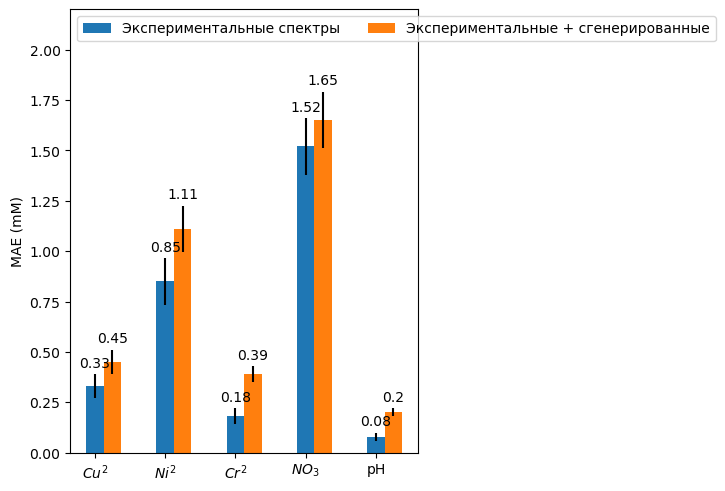

In [ ]:
species = (r'$Cu^2$', r'$Ni^2$', r'$Cr^3$', r'$NO_3$', "pH")
penguin_means = {
    'Экспериментальные спектры': (np.round(np.mean(cu_errors), 2), np.round(np.mean(ni_errors), 2), np.round(np.mean(cr_errors), 2), np.round(np.mean(no3_errors), 2), np.round(np.mean(ph_errors), 2)),
    'Экспериментальные + сгенерированные': (np.round(np.mean(cu_errors_gen), 2), np.round(np.mean(ni_errors_gen), 2), np.round(np.mean(cr_errors_gen), 2), np.round(np.mean(no3_errors_gen), 2), np.round(np.mean(ph_errors_gen), 2)
),
}

x = np.arange(len(species))
width = 0.25
multiplier = 1

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr = [np.round(np.std(cu_errors), 2), np.round(np.std(ni_errors), 2)/2, np.round(np.std(cr_errors), 2), np.round(np.std(no3_errors)/3, 2), np.round(np.std(ph_errors), 2)])
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('MAE (mM)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 2.2)

plt.show()